# Data Preparation

This is the **second** notebook of the analysis.

> Make sure you have executed the previous one [1_Explore.ipynb](1_Explore.ipynb), otherwise the packages might fail.
---

# Objective

After exploring the data. The following cells will prepare the dataset in a way that it could be consumed by a model capable of forecasting the wind speed based on a window of time (hours of a day).

At the end, a dataset will be pickled into a compressed file, which will be later used in the next processes (Train and Forecast)

---

# Reshaping Data

In the previous EDA (Exploratory Data Analysis) some statistical meaning was brought to the data. In order to train a Neural Network with such data, some reshaping is needed. 

By taking a closer look at the provided dataset, it is possible to observe that there is only one feature in the data, which is _wind velocity_. Therefore a single column dataset should be generated in order to train our model to forecast speed based on a given set of time.

In [1]:
import numpy as np
import pandas as pd
import plotly.express as px

df = pd.read_pickle('explore.pkl')
df.head()

,1,2,3,4,5,6,7,8,9,10,...,22,23,24,25,26,27,28,29,30,31
hour,,,,,,,,,,,,,,,,,,,,,
0,4.255,3.088,1.966,2.375,3.790,2.946,6.436,2.444,3.778,5.321,...,0.967,2.820,5.663,5.143,5.261,6.525,3.238,3.400,2.996,5.210
1,3.299,1.825,2.829,3.403,3.814,2.062,2.984,4.240,3.634,5.516,...,3.593,1.786,5.934,5.939,4.335,5.348,4.026,5.186,2.041,3.730
2,3.475,3.100,3.764,1.647,2.394,1.164,2.476,4.009,2.549,5.397,...,1.282,1.104,5.511,6.035,4.317,4.465,3.393,5.697,4.180,3.118
3,1.952,3.202,2.212,2.763,3.225,2.450,2.101,2.811,1.669,5.176,...,1.120,2.227,5.604,6.463,4.078,4.395,3.368,4.923,5.203,4.315
4,2.731,4.154,1.898,5.137,2.536,2.271,2.892,1.745,1.055,4.782,...,2.353,1.262,5.445,3.876,3.614,4.110,3.217,4.230,5.503,3.103


## Single Column

The next cell reshapes the dataset into a single column dataset containing all the velocities accross the time

In [2]:
def reshape(df: pd.DataFrame) -> pd.DataFrame:
    """Reshapes the provided Dataset into a single feature dataset
    
    
    """
    df = df.T.stack().to_frame()
    df.index = ['2021-01-{:02d} {:02d}:00'.format(int(i), j) for i, j in df.index]
    df = df.rename(columns={0: 'speed'})
    
    return df
    
df = reshape(df)
df

,speed
2021-01-01 00:00,4.255
2021-01-01 01:00,3.299
2021-01-01 02:00,3.475
2021-01-01 03:00,1.952
2021-01-01 04:00,2.731
...,...
2021-01-31 19:00,2.144
2021-01-31 20:00,1.565
2021-01-31 21:00,2.102
2021-01-31 22:00,2.031


### Visualizing the Time Series

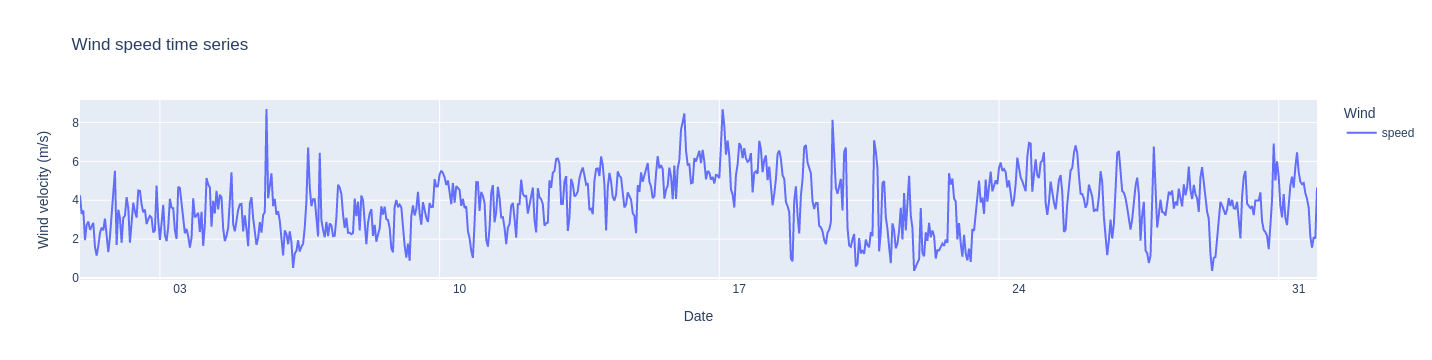

In [3]:
def plot_series(df):
    fig = px.line(df, title="Wind speed time series",
                  labels={
                         "value": "Wind velocity (m/s)",
                         "index": "Date",
                         "variable": "Wind"
                     })
    fig.update_xaxes(
        tickformat="%d",
        ticklabelmode="period")
    fig.show()
    
plot_series(df)

# Normalizing

One very important step is to normalize the data even though the model will be forecasting based on a single feature.

Here the package **scikit-learn** come in hand with functions to preprocess de data and also select our test and training sets

In [4]:
from sklearn import preprocessing

def normalize(df) -> pd.DataFrame:
    """Wind Speed normalization
    """
    indexes = df.index
    values = df.values
    scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
    scaled_values = scaler.fit_transform(values)
    df['normalized'] = scaled_values
    
    return df

df = normalize(df)
df

,speed,normalized
2021-01-01 00:00,4.255,0.467436
2021-01-01 01:00,3.299,0.352559
2021-01-01 02:00,3.475,0.373708
2021-01-01 03:00,1.952,0.190699
2021-01-01 04:00,2.731,0.284307
...,...,...
2021-01-31 19:00,2.144,0.213771
2021-01-31 20:00,1.565,0.144196
2021-01-31 21:00,2.102,0.208724
2021-01-31 22:00,2.031,0.200192


## Train and Test sets

Observation was record once every hour for a total of 31 days => (31*24) = 744 records. Since it is important to keep training and test sets cohesive, the split should be done in a way that each set makes sense from the time perspective. In that case.

 - ~ 70% $->$ **training**: 528 observations ranging from **2021-01-01 00:00** $\rightarrow$ **2021-01-22 23:00**
 - ~ 30% $->$ **test**: 216 observations ranging from **2021-01-23 00:00** $\rightarrow$ **2021-01-31 23:00**

In [5]:
from sklearn.model_selection import TimeSeriesSplit

def split(test_size:int):
    """Splits the dataset for training and testing
    """
    tscv = TimeSeriesSplit(n_splits=2, test_size=test_size)
    for train_index, test_index in tscv.split(df):
        train, test = df.iloc[train_index], df.iloc[test_index]
        
    return train, test

train, test = split(test_size=216)

In [6]:
train

,speed,normalized
2021-01-01 00:00,4.255,0.467436
2021-01-01 01:00,3.299,0.352559
2021-01-01 02:00,3.475,0.373708
2021-01-01 03:00,1.952,0.190699
2021-01-01 04:00,2.731,0.284307
...,...,...
2021-01-22 19:00,4.810,0.534126
2021-01-22 20:00,5.109,0.570055
2021-01-22 21:00,4.083,0.446768
2021-01-22 22:00,3.943,0.429945


## Rolling Windows

Since we are dealing with a Time Series, forecasting involves dealing with a "rolling window of time". Because of that, our model should be trained based on a specific "input window size" and an "output window size". This is equivalent of saying that we want our model to forecast $Y$ given $X$ where $Y$ is our prediction window, an $X$ is our learning window.

In order to do that, a specif function was created. Called `timeWindowCreator`, which takes specific rolling window parameters and ouputs datasets to be used for training and test.

In [7]:
def createTimeWindows(dataset, input_size: int, forecast_delay: int) -> (np.array, np.array):
    X, Y = [], []
    for i in range(0, dataset.shape[0] - input_size - 1):
        X.append(dataset[i:(i + input_size)])
        Y.append(dataset[i + input_size + forecast_delay - 1])

    X,Y = np.array(X), np.array(Y)
    return np.reshape(X, (X.shape[0], 1, X.shape[-1])), Y

In [8]:
input_size = 4
forecast_delay = 2
output_size = 1

trainX, trainY = createTimeWindows(train['normalized'].values, 4, 2)
testX, testY = createTimeWindows(test['normalized'].values, 4, 2)

## Model

After preparing datasets for training and testing. Now its the time to setup the Neural Network model. 

Since the objetive is to use a Neural Network framework (in this case Keras), the next step is to initialize a model considering a set of parameters.

There are inumerous topologies of neural networks available. An interesting one, is the Long short-term memory. Which is considered the most simple recurrent neural network and widely used in time series prediction.

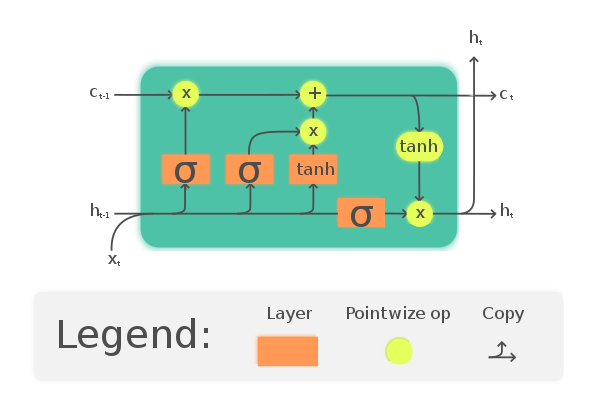

The Long Short-Term Memory (LSTM) cell can process data sequentially and keep its hidden state through time.

The next cell creates a function to initialize a model, based on LTSM topology.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

def init_model(input_size, output_size, activation_function, loss_metric, optimizer):
    
    units = int((input_size * 0.67) + (output_size * 0.33))
    input_shape = (1, input_size)
    
    model = Sequential()
    tf.keras.optimizers.Adam(learning_rate=1e-5, beta_1=0.9, beta_2=0.999,
                                 epsilon=1e-07, amsgrad=False, name="adam")
    model.add(LSTM(units=units, input_shape=input_shape))
    model.add(Dense(1, activation=activation_function))

    metrics = tf.keras.metrics.RootMeanSquaredError()

    model.compile(
        loss=loss_metric,
        metrics=[metrics],
        optimizer=optimizer)
    
    return model

In [11]:
model = init_model(input_size=4, output_size=1, activation_function='tanh', loss_metric='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 3)                 96        
_________________________________________________________________
dense (Dense)                (None, 1)                 4         
Total params: 100
Trainable params: 100
Non-trainable params: 0
_________________________________________________________________


2021-07-08 18:24:24.307600: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-07-08 18:24:24.307620: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-07-08 18:24:24.307651: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (HM01): /proc/driver/nvidia/version does not exist
2021-07-08 18:24:24.307863: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Saving Models

There are two types of forecasting we want to make:

 - **record(s) in the past** being used to predict **record(s) in the future**
 - **single time step** (specific hour of the day) being used to predic the values of a **single time step** in the future
 
The previously created functions can be wraped up in a single class. To further enhance the abstraction of our model

In [12]:
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn import preprocessing
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

class WindForecaster:
    def __init__(self, df:pd.DataFrame, test_size: int, prediction_window: int,
                       forecast_delay: int, forecast_size: int, activation_function: str,
                       loss_metric: str, optimizer: str):
        
        
        self.dataset = self.__normalize(self.__reshape(df))
        self.train_set, self.test_set = self.__split(test_size)
        
        self.train_X, self.train_Y = self.__createTimeWindows(
            dataset=self.train_set['normalized'].values,
            prediction_window=prediction_window,
            forecast_delay=forecast_delay)
        
        self.test_X, self.test_Y = self.__createTimeWindows(
            dataset=self.test_set['normalized'].values,
            prediction_window=prediction_window,
            forecast_delay=forecast_delay)
        
        self.model = self.__init_model(prediction_window=prediction_window, forecast_size=forecast_size,
                                       activation_function=activation_function, loss_metric=loss_metric,
                                       optimizer=optimizer)
        
    def __reshape(self, df) -> pd.DataFrame:
        """Reshapes the provided Dataset into a single feature dataset
        """
        df = df.T.stack().to_frame()
        df.index = ['2021-01-{:02d} {:02d}:00'.format(int(i), j) for i, j in df.index]
        df = df.rename(columns={0: 'speed'})

        return df
    
    def __normalize(self, df) -> pd.DataFrame:
        """Wind Speed normalization
        """
        indexes = df.index
        values = df.values
        scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
        scaled_values = scaler.fit_transform(values)
        df['normalized'] = scaled_values

        return df

    def __split(self, test_size:int):
        """Splits the dataset for training and testing
        """
        tscv = TimeSeriesSplit(n_splits=2, test_size=test_size)
        for train_index, test_index in tscv.split(self.dataset):
            train, test = self.dataset.iloc[train_index], self.dataset.iloc[test_index]

        return train, test
    
    def __createTimeWindows(self,dataset, prediction_window: int, forecast_delay: int) -> (np.array, np.array):
        """Creates time windows, which could be used for prediction or testing
        """
        X, Y = [], []
        for i in range(0, dataset.shape[0] - prediction_window - 1):
            X.append(dataset[i:(i + prediction_window)])
            Y.append(dataset[i + prediction_window + forecast_delay - 1])

        X,Y = np.array(X), np.array(Y)
        return np.reshape(X, (X.shape[0], 1, X.shape[-1])), Y
    
    def __init_model(self, prediction_window: int, forecast_size: int,
                     activation_function: str, loss_metric: str, optimizer: str):
    
        units = int((prediction_window * 0.67) + (forecast_size * 0.33))
        input_shape = (1, prediction_window)

        model = Sequential()
        tf.keras.optimizers.Adam(learning_rate=1e-5, beta_1=0.9, beta_2=0.999,
                                     epsilon=1e-07, amsgrad=False, name="adam")
        model.add(LSTM(units=units, input_shape=input_shape))
        model.add(Dense(1, activation=activation_function))

        metrics = tf.keras.metrics.RootMeanSquaredError()

        model.compile(
            loss=loss_metric,
            metrics=[metrics],
            optimizer=optimizer)

        return model
    
    def __repr__(self):
        self.model.summary()
        return ""
        

### Building Model

Now the class `WindForecaster` can be used to build a model. In the next notebook this class will be enhanced in order to train the model.

In [13]:
df = pd.read_pickle('explore.pkl')

WindForecaster = WindForecaster(df=df,
                                test_size=216,
                                prediction_window=4,
                                forecast_delay=2,
                                forecast_size=1,
                                activation_function='tanh',
                                loss_metric="mean_squared_error",
                                optimizer="adam")

In [14]:
WindForecaster

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 3)                 96        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 4         
Total params: 100
Trainable params: 100
Non-trainable params: 0
_________________________________________________________________
